# My realization GMT_trend2d vs library based robust_trend2d

See pygmtsar.PRM class for my realization of GMT compatible robust trend estimator named before GMT_trend2d

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
def GMT_trend2d(data, rank):
    import numpy as np
    from sklearn.linear_model import LinearRegression
    # scale factor for normally distributed data is 1.4826
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_abs_deviation.html
    MAD_NORMALIZE = 1.4826
    # significance value
    sig_threshold = 0.51

    if rank not in [1,2,3]:
        raise Exception('Number of model parameters "rank" should be 1, 2, or 3')

    #see gmt_stat.c
    def gmtstat_f_q (chisq1, nu1, chisq2, nu2):
        import scipy.special as sc

        if chisq1 == 0.0:
            return 1
        if chisq2 == 0.0:
            return 0
        return sc.betainc(0.5*nu2, 0.5*nu1, chisq2/(chisq2+chisq1))

    if rank in [2,3]:
        x = data[:,0]
        x = np.interp(x, (x.min(), x.max()), (-1, +1))
    if rank == 3:
        y = data[:,1]
        y = np.interp(y, (y.min(), y.max()), (-1, +1))
    z = data[:,2]
    w = np.ones(z.shape)

    if rank == 1:
        xy = np.expand_dims(np.zeros(z.shape),1)
    elif rank == 2:
        xy = np.expand_dims(x,1)
    elif rank == 3:
        xy = np.stack([x,y]).transpose()

    # create linear regression object
    mlr = LinearRegression()

    chisqs = []
    coeffs = []
    while True:
        # fit linear regression
        mlr.fit(xy, z, sample_weight=w)

        r = np.abs(z - mlr.predict(xy))
        chisq = np.sum((r**2*w))/(z.size-3)    
        chisqs.append(chisq)
        k = 1.5 * MAD_NORMALIZE * np.median(r)
        w = np.where(r <= k, 1, (2*k/r) - (k * k/(r**2)))
        sig = 1 if len(chisqs)==1 else gmtstat_f_q(chisqs[-1], z.size-3, chisqs[-2], z.size-3)
        # Go back to previous model only if previous chisq < current chisq
        if len(chisqs)==1 or chisqs[-2] > chisqs[-1]:
            coeffs = [mlr.intercept_, *mlr.coef_]

        #print ('chisq', chisq, 'significant', sig)
        if sig < sig_threshold:
            break

    # get the slope and intercept of the line best fit
    return (coeffs[:rank])

In [3]:
import numpy as np
import statsmodels.api as sm

def robust_trend2d(data, rank):
    if rank not in [1, 2, 3]:
        raise Exception('Number of model parameters "rank" should be 1, 2, or 3')

    if rank in [2, 3]:
        x = data[:, 0]
        x = np.interp(x, (x.min(), x.max()), (-1, +1))
    if rank == 3:
        y = data[:, 1]
        y = np.interp(y, (y.min(), y.max()), (-1, +1))
    z = data[:, 2]

    if rank == 1:
        X = sm.add_constant(np.ones(z.shape))
    elif rank == 2:
        X = sm.add_constant(x)
    elif rank == 3:
        X = sm.add_constant(np.column_stack((x, y)))

    rlm_model = sm.RLM(z, X)
    rlm_results = rlm_model.fit()

    return rlm_results.params[:rank]

In [4]:
def generate_data(rank, num_points, noise_level):
    np.random.seed(42)
    x = np.linspace(-10, 10, num_points)
    y = np.linspace(-10, 10, num_points)
    if rank == 1:
        z = 3 * x + 5 + noise_level * np.random.randn(num_points)
        data = np.column_stack((x, y, z))
    elif rank == 2:
        z = 2 * x + 3 * y + 5 + noise_level * np.random.randn(num_points)
        data = np.column_stack((x, y, z))
    elif rank == 3:
        z = 2 * x**2 + 3 * y**2 + 5 + noise_level * np.random.randn(num_points)
        data = np.column_stack((x, y, z))
    return data

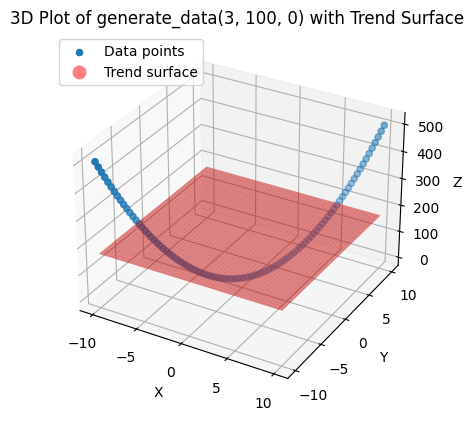

In [5]:
data = generate_data(3, 100, 0)
coefficients = robust_trend2d(data, 3)

x = data[:, 0]
y = data[:, 1]
X, Y = np.meshgrid(x, y)
Z = coefficients[0] + coefficients[1] * (X**2) + coefficients[2] * (Y**2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
data_points = ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="Data points")
surface = ax.plot_surface(X, Y, Z, alpha=0.5, color='r')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Plot of generate_data(3, 100, 0) with Trend Surface")

# Create a custom proxy artist for the legend entry
surface_proxy = Line2D([0], [0], linestyle='none', mfc='red', alpha=0.5, mec='none', marker='o', markersize=10)
ax.legend([data_points, surface_proxy], ['Data points', 'Trend surface'], loc='upper left')

plt.show()

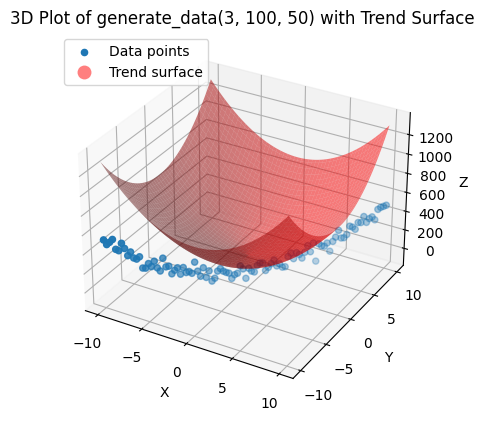

In [6]:
data = generate_data(3, 100, 50)
coefficients = robust_trend2d(data, 3)

x = data[:, 0]
y = data[:, 1]
X, Y = np.meshgrid(x, y)
Z = coefficients[0] + coefficients[1] * (X**2) + coefficients[2] * (Y**2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
data_points = ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="Data points")
surface = ax.plot_surface(X, Y, Z, alpha=0.5, color='r')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Plot of generate_data(3, 100, 50) with Trend Surface")

# Create a custom proxy artist for the legend entry
surface_proxy = Line2D([0], [0], linestyle='none', mfc='red', alpha=0.5, mec='none', marker='o', markersize=10)
ax.legend([data_points, surface_proxy], ['Data points', 'Trend surface'], loc='upper left')

plt.show()

In [7]:
import numpy as np
from tabulate import tabulate

def calculate_mse(data, coeffs, rank):
    x = data[:, 0]
    y = data[:, 1]
    z_actual = data[:, 2]

    if rank == 1:
        z_predicted = coeffs[0]
    elif rank == 2:
        z_predicted = coeffs[0] + coeffs[1] * x
    elif rank == 3:
        z_predicted = coeffs[0] + coeffs[1] * x + coeffs[2] * y

    mse = np.mean((z_actual - z_predicted) ** 2)
    return mse


def test_mse(num_points = 100*1000, ranks = [1, 2, 3], noise_levels = [0, 1, 10, 50]):
    import warnings

    results = []
    # Suppress the specific warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for rank in ranks:
            for noise_level in noise_levels:
                data = generate_data(rank, num_points, noise_level)
                # round the output
                coeffs_gmt = [v.round(8) for v in GMT_trend2d(data, rank)]
                coeffs_robust = robust_trend2d(data, rank)

                mse_gmt = np.round(calculate_mse(data, coeffs_gmt, rank), 0)
                mse_robust = np.round(calculate_mse(data, coeffs_robust, rank), 0)

                winner = "GMT_trend2d" if mse_gmt < mse_robust else "robust_trend2d"

                diff = np.round(100*(mse_gmt/mse_robust if mse_gmt < mse_robust else mse_robust/mse_gmt), 2)

                results.append([rank, noise_level, mse_gmt, mse_robust, winner, diff])

    headers = ["Rank", "Noise Level", "GMT_trend2d, MSE", "robust_trend2d, MSE", "Winner", "%"]
    print(tabulate(results, headers=headers))

test_mse()

  Rank    Noise Level    GMT_trend2d, MSE    robust_trend2d, MSE  Winner               %
------  -------------  ------------------  ---------------------  --------------  ------
     1              0                 300                    300  robust_trend2d  100
     1              1                 301                    301  robust_trend2d  100
     1             10                 400                    400  robust_trend2d  100
     1             50                2805                   2805  robust_trend2d  100
     2              0               67501                  67501  robust_trend2d  100
     2              1               67502                  67502  robust_trend2d  100
     2             10               67594                  67596  GMT_trend2d     100
     2             50               69969                  69978  GMT_trend2d      99.99
     3              0               22335                  22248  robust_trend2d   99.61
     3              1               22356 

In [8]:
import numpy as np
import time
from tabulate import tabulate

def measure_time(func, data, rank, n_runs):
    start_time = time.perf_counter()
    _ = [func(data, rank) for i in range(n_runs)]
    end_time = time.perf_counter()
    return (end_time - start_time)/n_runs

# aligning uses 50...100 ksamples for a few subswaths
def test_time(num_points = 100*1000, n_runs = 50, ranks = [1, 2, 3], noise_levels = [0, 1, 10, 50]):
    import warnings
    
    results = []
    # Suppress the specific warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for rank in ranks:
            for noise_level in noise_levels:
                data = generate_data(rank, num_points, noise_level)

                gmt_time = np.round(1000*measure_time(GMT_trend2d, data, rank, n_runs), 0)
                robust_time = np.round(1000*measure_time(robust_trend2d, data, rank, n_runs), 0)

                winner = "GMT_trend2d" if gmt_time < robust_time else "robust_trend2d"

                diff = np.round(100*(gmt_time/robust_time if gmt_time < robust_time else robust_time/gmt_time), 0)

                results.append([rank, noise_level, gmt_time, robust_time, winner, diff])

    headers = ["Rank", "Noise Level", "GMT_trend2d, [ms]", "robust_trend2d, [ms]", "Winner", "%"]
    print(tabulate(results, headers=headers))

test_time()

  Rank    Noise Level    GMT_trend2d, [ms]    robust_trend2d, [ms]  Winner         %
------  -------------  -------------------  ----------------------  -----------  ---
     1              0                   14                     139  GMT_trend2d   10
     1              1                    8                     158  GMT_trend2d    5
     1             10                   14                     302  GMT_trend2d    5
     1             50                   15                     282  GMT_trend2d    5
     2              0                    8                    1001  GMT_trend2d    1
     2              1                   13                     301  GMT_trend2d    4
     2             10                   13                     270  GMT_trend2d    5
     2             50                   13                     224  GMT_trend2d    6
     3              0                   45                    1185  GMT_trend2d    4
     3              1                   36                    115

## Some Improvements #1

In [9]:
import numpy as np
import statsmodels.api as sm

def robust_trend2d(data, rank):
    if rank not in [1, 2, 3]:
        raise Exception('Number of model parameters "rank" should be 1, 2, or 3')

    if rank in [2, 3]:
        x = data[:, 0]
        x = np.interp(x, (x.min(), x.max()), (-1, +1))
    if rank == 3:
        y = data[:, 1]
        y = np.interp(y, (y.min(), y.max()), (-1, +1))
    z = data[:, 2]

    if rank == 1:
        X = sm.add_constant(np.ones(z.shape))
    elif rank == 2:
        X = sm.add_constant(x)
    elif rank == 3:
        X = sm.add_constant(np.column_stack((x, y)))

    # Iterate only once for the RLM model
    rlm_model = sm.RLM(z, X, M=sm.robust.norms.HuberT(), hasconst=True)
    rlm_results = rlm_model.fit(update_scale=False, maxiter=1)

    return rlm_results.params[:rank]


In [10]:
test_mse()

  Rank    Noise Level    GMT_trend2d, MSE    robust_trend2d, MSE  Winner               %
------  -------------  ------------------  ---------------------  --------------  ------
     1              0                 300                    300  robust_trend2d  100
     1              1                 301                    301  robust_trend2d  100
     1             10                 400                    400  robust_trend2d  100
     1             50                2805                   2805  robust_trend2d  100
     2              0               67501                  67501  robust_trend2d  100
     2              1               67502                  67502  robust_trend2d  100
     2             10               67594                  67598  GMT_trend2d      99.99
     2             50               69969                  69989  GMT_trend2d      99.97
     3              0               22335                  22231  robust_trend2d   99.53
     3              1               223

In [11]:
test_time()

  Rank    Noise Level    GMT_trend2d, [ms]    robust_trend2d, [ms]  Winner         %
------  -------------  -------------------  ----------------------  -----------  ---
     1              0                    7                      38  GMT_trend2d   18
     1              1                    7                      28  GMT_trend2d   25
     1             10                   10                      32  GMT_trend2d   31
     1             50                   13                      32  GMT_trend2d   41
     2              0                    8                      63  GMT_trend2d   13
     2              1                   13                      59  GMT_trend2d   22
     2             10                   13                      57  GMT_trend2d   23
     2             50                   12                      66  GMT_trend2d   18
     3              0                   43                      80  GMT_trend2d   54
     3              1                   38                      8

## Some Improvements #2

By default, sm.RLM uses the Huber's t weighting function. There are some other weighting functions such as Tukey's biweight or the Hampel weighting function. 

In [12]:
def robust_trend2d(data, rank):
    if rank not in [1, 2, 3]:
        raise Exception('Number of model parameters "rank" should be 1, 2, or 3')

    if rank in [2, 3]:
        x = data[:, 0]
        x = np.interp(x, (x.min(), x.max()), (-1, +1))
    if rank == 3:
        y = data[:, 1]
        y = np.interp(y, (y.min(), y.max()), (-1, +1))
    z = data[:, 2]

    if rank == 1:
        X = sm.add_constant(np.ones(z.shape))
    elif rank == 2:
        X = sm.add_constant(x)
    elif rank == 3:
        X = sm.add_constant(np.column_stack((x, y)))

    rlm_model = sm.RLM(z, X, M=sm.robust.norms.Hampel())
    rlm_results = rlm_model.fit()

    return rlm_results.params[:rank]

In [13]:
test_mse()

  Rank    Noise Level    GMT_trend2d, MSE    robust_trend2d, MSE  Winner               %
------  -------------  ------------------  ---------------------  --------------  ------
     1              0                 300                    300  robust_trend2d  100
     1              1                 301                    301  robust_trend2d  100
     1             10                 400                    400  robust_trend2d  100
     1             50                2805                   2805  robust_trend2d  100
     2              0               67501                  67501  robust_trend2d  100
     2              1               67502                  67501  robust_trend2d  100
     2             10               67594                  67587  robust_trend2d   99.99
     2             50               69969                  69931  robust_trend2d   99.95
     3              0               22335                  22220  robust_trend2d   99.49
     3              1               223

In [14]:
test_time()

  Rank    Noise Level    GMT_trend2d, [ms]    robust_trend2d, [ms]  Winner         %
------  -------------  -------------------  ----------------------  -----------  ---
     1              0                    7                      35  GMT_trend2d   20
     1              1                    6                      38  GMT_trend2d   16
     1             10                   14                      79  GMT_trend2d   18
     1             50                   10                     108  GMT_trend2d    9
     2              0                   10                      71  GMT_trend2d   14
     2              1                   13                     229  GMT_trend2d    6
     2             10                   15                     215  GMT_trend2d    7
     2             50                   12                     190  GMT_trend2d    6
     3              0                   54                      95  GMT_trend2d   57
     3              1                   42                      9

## Example

In [15]:
GMT_trend2d(generate_data(3,100, 1), 3), robust_trend2d(generate_data(3,100, 1), 3)

([174.83558692846418, 0.03710470618011453, 0.037104706180114515],
 array([1.74929824e+02, 3.44831683e-02, 3.44831683e-02]))